<a href="https://colab.research.google.com/github/structural-engineering-ai/gpr_corrosion_ai/blob/main/GPR_Model_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import tqdm


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


## Data - Load and Create Dataloaders

In [ ]:
# check device type
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# raw data files
rebar_ng = '/content/drive/MyDrive/gssi_data/train_data/rebar_ng_numpy'
rebar_ok = '/content/drive/MyDrive/gssi_data/train_data/rebar_ok_numpy'

In [ ]:
# hyperparameters
BATCH_SIZE = 32
BOOST = 3   # number of times to boost training set

D_START_CLIP = 100
D_END_CLIP = 250
D_CLIP = D_END_CLIP - D_START_CLIP
D_COLUMNS = 10
RADAR_CLIP = 6

In [ ]:
class GPRDataset(Dataset):
    def __init__(self, file_list, train=True):
        self.file_list = file_list
        self.train = train

        self.data = []
        self.labels = []

        for file_ in self.file_list:
            # load file
            data_ = np.load(file_)
            # clip to same size
            data_ = data_[D_START_CLIP:D_END_CLIP,:D_COLUMNS]
            self.data.append(data_)

            # check file and generate label
            if self.has_folder_name(file_, "rebar_ng_numpy"):
                self.labels.append(0)
            if self.has_folder_name(file_, "rebar_ok_numpy"):
                self.labels.append(1)

    def __len__(self):
        return len(self.data)

    def has_folder_name(self, file_path, folder_name):
        file_path_components = os.path.split(file_path)[0]
        return folder_name in file_path_components

    def normalize_array(self, x):
        mean = np.mean(x)
        std = np.std(x)
        normalized_array = (x - mean) / std
        return normalized_array

    def flip_signal(self, x):
        x = np.flip(x, axis=-1)
        flip = x.copy()
        return flip

    def random_shift(self, x):
        # Create a random shift for entire rows of data
        random_number = np.random.randint(0, 20)
        top = 0
        bottom = 0

        if random_number > 10:
            top = random_number
        else:
            bottom = random_number

        shifted_array = np.pad(x, ((top, bottom),(0,0)), 'constant')
        shifted_array = shifted_array[:D_CLIP, :]

        return shifted_array

    def clip_signal(self, x):
        start_index = 0

        if self.train:
            start_index = np.random.randint(0, 11-RADAR_CLIP)

        clip = x[:, start_index:start_index + RADAR_CLIP]
        return clip

    def apply_augmentations(self, x):
        # flip signal - mirror
        random_number = random.random()
        if random_number > 0.5:
            x = self.flip_signal(x)

        # shift signal
        x = self.random_shift(x)
        return x

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]

        # normalize and augment data
        x = self.normalize_array(x)

        # clip signal
        x = self.clip_signal(x)

        # augment training data
        if self.train:
            x = self.apply_augmentations(x)

        # convert to tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.uint8)

        # add channel for 2d Cnn
        rows = D_CLIP
        x = x.view(1, rows, RADAR_CLIP)

        return x, y

In [ ]:
def get_file_paths(file_folder):
    paths = []
    # get list of files in folder
    file_names = os.listdir(file_folder)

    # append folder path to file name
    for file_name in file_names:
        # check that file has DZT extension
        _, file_extension = os.path.splitext(file_name)

        if file_extension == '.npy':
            path = os.path.join(file_folder, file_name)
            paths.append(path)

    return paths

In [ ]:
def split_train_val_test(files_1, files_2, val_size = 0.2, test_size=0.05):
    # splits files into training and test sets - shuffled - returns test and
    # training file path lists

    train_files = []
    val_files = []
    test_files = []

    # shuffle file lists - better mix of test and training data
    random.shuffle(files_1)
    random.shuffle(files_2)

    # calculate split points
    train_split_point1 = int(len(files_1) * (1 - (val_size + test_size)))
    test_split_point1 = int(len(files_1) * (1 - test_size))

    train_split_point2 = int(len(files_2) * (1 - (val_size + test_size)))
    test_split_point2 = int(len(files_2) * (1 - test_size))

    # split files
    train_files_1 = files_1[:train_split_point1]
    val_files_1 = files_1[train_split_point1:test_split_point1]
    test_files_1 = files_1[test_split_point1:]

    train_files_2 = files_2[:train_split_point2]
    val_files_2 = files_2[train_split_point2:test_split_point2]
    test_files_2 = files_2[test_split_point2:]

    # combine files
    train_files = train_files_1 + train_files_2
    val_files = val_files_1 + val_files_2
    test_files = test_files_1 + test_files_2

    # shuffle files to mix folders
    random.shuffle(train_files)
    random.shuffle(val_files)
    random.shuffle(test_files)

    return train_files, val_files, test_files

In [ ]:
# add paths to files so its easier to shuffle and combine
ng_file_paths = get_file_paths(rebar_ng)
ok_file_paths = get_file_paths(rebar_ok)

# get training and test file lists
train_file_paths, val_file_paths, test_file_paths = split_train_val_test(ng_file_paths, ok_file_paths)

In [ ]:
print(f'train_file_paths: {len(train_file_paths)}   val_file_paths:{len(val_file_paths)}    test_file_paths:{len(test_file_paths)}')

train_file_paths: 417   val_file_paths:112    test_file_paths:28


In [ ]:
# update length of training to be divisible by batch size
len_train = int(len(train_file_paths) // BATCH_SIZE) * BATCH_SIZE

In [ ]:
# trim training files to keep it divisible by batch size - not doing padding
train_file_paths = train_file_paths[:len_train]

In [ ]:
# build the custom dataset - clipping and flipping bars
train = True
test = False
train_dataset = GPRDataset(train_file_paths, train)
val_dataset = GPRDataset(val_file_paths, test)
test_dataset = GPRDataset(test_file_paths, test)

In [ ]:
print(f'train_dataset: {len(train_dataset)}   val_dataset:{len(val_dataset)}  test_dataset:{len(test_dataset)}')

train_dataset: 416   val_dataset:112  test_dataset:28


In [ ]:
# create dataloaders with batch and shuffle
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=28)

## Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layer 1  -> out: ([batch, 32, 35, 6])
        self.conv1 = nn.Conv2d(1, 256, (11, 3), stride=(4,1), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(256)
        self.relu1 = nn.ELU()
        self.dropout1 = nn.Dropout(p=0.6)

        # Convolutional layer 2  -> out: ([batch, 64, 9, 4])
        self.conv2 = nn.Conv2d(256, 256, (9, 3), stride=(3,1), padding=0)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.ELU()
        self.dropout2 = nn.Dropout(p=0.6)

        # Convolutional layer 3    -> out: ([batch, 1, 3, 3])
        self.conv3 = nn.Conv2d(256, 256, (5, 2), stride=(2,1), padding=0)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ELU()
        self.dropout3 = nn.Dropout(p=0.6)

        # Fully convolutional layer 1  -> out: ([batch, 1, 1, 1])
        self.conv4 = nn.Conv2d(256, 1, kernel_size=(3,3), stride=(2,1), padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convolutional layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        # Convolutional layer 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        # Convolutional layer 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        # Fully convolutional layer 1
        x = self.conv4(x)
        x = self.sigmoid(x)
        x = torch.flatten(x)
        x = torch.squeeze(x)

        return x

In [ ]:
# create a model instance
model = CNN()
model.to(device)

#loss function
loss_fn = nn.BCELoss()

# optimizer function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create the learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0 = 10,# Number of iterations for the first restart
                                        T_mult = 2, # A factor increases TiTi​ after a restart
                                        eta_min = 1e-6, # Minimum learning rate
                                        last_epoch = -1)

# model hyperparameters
epoch_number = 0
EPOCHS = 1000

training_losses = []
val_losses = []
learning_rates = []
last_train_batch = len(train_dataloader) - 1
last_val_batch = len(val_dataloader) - 1

# initialize the best validation loss
best_val_loss = float('inf')

# run model
for epoch in range(EPOCHS):
    ave_training_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_dataloader):
        # put data on device
        data, labels = data.to(device), labels.to(device)

        # set model to training mode
        model.train()

        # forward pass
        output = model(data)

        # calculate the loss
        loss = loss_fn(output.float(), labels.float())

        # backward pass and update the model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # add the loss to the average training loss
        ave_training_loss += loss.item()

    # calculate average training loss for the epoch
    ave_training_loss /= len(train_dataloader)

    # add the average trainin loss to the training losses list
    training_losses.append(ave_training_loss)

    # print training loss
    print(f'EPOCH {epoch_number + 1}:')
    print(f'Training Loss: {ave_training_loss:.3f}')

    # record learning rate
    learning_rates.append(optimizer.param_groups[0]["lr"])

    # validation loop
    with torch.no_grad():
        ave_val_loss = 0.0

        for batch_idx, (data, labels) in enumerate(val_dataloader):
            # put data on device
            data, labels = data.to(device), labels.to(device)

            # set model to training mode
            model.eval()

            # forward pass
            output = model(data)

            # calculate the loss
            loss = loss_fn(output.float(), labels.float())

            # update the best validation loss if necessary
            if loss < best_val_loss:
                best_val_loss = loss
                best_model_weights = model.state_dict()
                print(f'Best loss: {best_val_loss}')

            # add the loss to the training losses list
            ave_val_loss += loss.item()

        # calculate average validation loss for the epoch
        ave_val_loss /= len(val_dataloader)

        # add the average validation loss to the list
        val_losses.append(ave_val_loss)

        # print validation loss
        print(f'Validation Loss: {ave_val_loss:.3f}')


    # Update the learning rate
    scheduler.step(loss)

    # update the epoch
    epoch_number += 1

# save the model weights adn model of the best model
torch.save(best_model_weights, '/content/drive/MyDrive/gssi_model/best_model_weights2b.pt')

EPOCH 1:
Training Loss: 0.792
Best loss: 0.987663984298706
Best loss: 0.9174373149871826
Best loss: 0.8145002126693726
Validation Loss: 1.006
EPOCH 2:
Training Loss: 0.808
Best loss: 0.773321270942688
Best loss: 0.6892081499099731
Best loss: 0.5052650570869446
Validation Loss: 0.687
EPOCH 3:
Training Loss: 0.726
Validation Loss: 0.673
EPOCH 4:
Training Loss: 0.700
Validation Loss: 0.662
EPOCH 5:
Training Loss: 0.705
Validation Loss: 0.669
EPOCH 6:
Training Loss: 0.701
Validation Loss: 0.609
EPOCH 7:
Training Loss: 0.706
Validation Loss: 0.630
EPOCH 8:
Training Loss: 0.691
Validation Loss: 0.595
EPOCH 9:
Training Loss: 0.695
Validation Loss: 0.612
EPOCH 10:
Training Loss: 0.700
Validation Loss: 0.641
EPOCH 11:
Training Loss: 0.704
Validation Loss: 0.630
EPOCH 12:
Training Loss: 0.681
Validation Loss: 0.616
EPOCH 13:
Training Loss: 0.660
Validation Loss: 0.634
EPOCH 14:
Training Loss: 0.673
Validation Loss: 0.733
EPOCH 15:
Training Loss: 0.731
Validation Loss: 0.668
EPOCH 16:
Training Lo

In [ ]:
# best val_loss
print(best_val_loss)

tensor(0.2002, device='cuda:0')


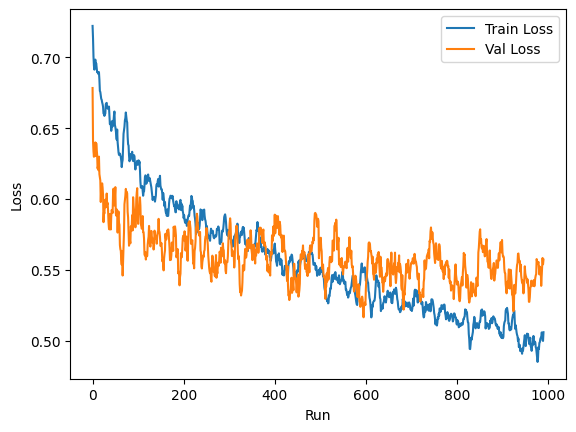

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# calculate moving average of the losses
smoothed_training_loss = moving_average(training_losses, 10)
smoothed_val_loss = moving_average(val_losses, 10)

# plot the training and validation losses
plt.plot(smoothed_training_loss, label='Train Loss')
plt.plot(smoothed_val_loss, label='Val Loss')
plt.xlabel('Run')
plt.ylabel('Loss')
plt.legend()
plt.show()

## TEST MODEL

In [ ]:
 # load saved weights
best_model_weights = torch.load('/content/drive/MyDrive/gssi_model/best_model_weights2b.pt')

# create a new model instance
best_model = CNN()

# load the saved weights into the model
best_model.load_state_dict(best_model_weights)

num_correct = 0
num_samples = 0

best_model.to(device)

# set model to training mode
best_model.eval()

with torch.no_grad():
    for _ , (data, labels) in enumerate(test_dataloader):
        # put data on device
        data = data.float().to(device)
        labels = labels.float().to(device)

        # forward pass
        output = best_model(data)

        rounded = torch.round(output)

        num_correct += (rounded == labels).sum()
        num_samples += rounded.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

Got 23 / 28 with accuracy 82.14
